# Introduction

In this notebook, we want to study the two datasets in `beerAdv_beer_brewery.tsv` and in `rateBeer_beer_brewery.tsv`. The columns of these datasets are like this:

              beer_id ¦ beer_name ¦ brewery_id ¦ brewery_name
            
The idea of this notebook is to create a similarity measure in order to find the same elements in both these datasets. Once we have this similarity measure, we want to find the limit X such that:
- All pairs with a similarity value of $X' > X$ are considered as the same beer
- All pairs with a similarity value of $X'' < X$ are not taken into account.

In order to achieve this, this notebook is composed of three parts. The first part is some sort of simple Data Analysis. Then there will be the creation of the pairs and the similarity value. Finally the part to find the best value $X$.

## Table of contents

1. [Data Analysis](#data_analysis)
2. [Similarity Measure](#similarity)
3. [Matching the beers](#matching) 

Each parts is separated. Therefore, you don't have to run the previous parts in order to run a specific part.

In [1]:
# Usefule imports
import pandas as pd
import numpy as np
import codecs
from IPython.display import HTML
import matplotlib.pyplot as plt

from fuzzywuzzy import fuzz
import multiprocessing
from joblib import Parallel, delayed
import pickle

# For the Pyth§on notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

<a id='data_analysis'></a>

## Data Analysis

First, we need to analyze the data. It's a simple data analysis since we only have two usefull features: `beer_name` and `brewery_name`.

In [2]:
# Datasets
beerAdvocate_dataset = './data/beerAdv_beer_brewery.tsv'
rateBeer_dataset = './data/rateBeer_beer_brewery.tsv'

In [3]:
columns = ['beer_id', 'beer_name', 'brewery_id', 'brewery_name']

In [4]:
# Load the dataset with pandas
beerAdvocate = pd.read_table(beerAdvocate_dataset, header=None)
beerAdvocate.columns = columns
rateBeer = pd.read_table(rateBeer_dataset, header=None, encoding='utf-8')
rateBeer.columns = columns

Print the two datasets

In [6]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [7]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


We just stop two minutes here. We can see a problem with the encoding of the file for *beerAdvocate*. 

In [8]:
name = beerAdvocate.ix[12].beer_name
print(name)

Master PolotmavÃ½ 13Â°


The encoding here is **latin_1**. Therefore, we can find the UTF-8 encoding by doing this:

In [9]:
new_name = bytes(name,'latin_1').decode('utf-8')
print(new_name)

Master Polotmavý 13°


Let's do it everywhere for *beerAdvocate*!

In [10]:
def decode_from_latin_1(string):
    try:
        return bytes(string ,'latin_1').decode('utf-8')
    except:
        return string

In [11]:
for i in range(len(beerAdvocate)):
    # Change the name of the beer
    beerAdvocate.set_value(i, 'beer_name', decode_from_latin_1(beerAdvocate.ix[i].beer_name))
    beerAdvocate.set_value(i, 'brewery_name', decode_from_latin_1(beerAdvocate.ix[i].brewery_name))


In [12]:
beerAdvocate.ix[12].beer_name

'Master Polotmavý 13°'

Let's print the number of entries in each dataset.

In [13]:
print("Number of rows in beerAdvocate: %i"%(len(beerAdvocate)))
print("Number of rows in rateBeer: %i"%(len(rateBeer)))

Number of rows in beerAdvocate: 66056
Number of rows in rateBeer: 110359


Let's check the number of **unique** beers to see if it matches the number of rows in the dataset.

In [14]:
unique_beers_beerAdvocate = beerAdvocate.beer_name.unique()
unique_beers_rateBeer = rateBeer.beer_name.unique()

print("Number of unique beers in beerAdvocate: %i"%(len(unique_beers_beerAdvocate)))
print("Number of unique beers in rateBeer: %i"%(len(unique_beers_rateBeer)))

Number of unique beers in beerAdvocate: 56855
Number of unique beers in rateBeer: 110302


It's already interesting to see that some beers have the same name in both datasets. Let's take one of them and see if they have the same `brewery_name`.

In [15]:
duplicated_beers_beerAdvocate = beerAdvocate[beerAdvocate.beer_name.duplicated()].beer_name.unique()
duplicated_beers_rateBeer = rateBeer[rateBeer.beer_name.duplicated()].beer_name.unique()

print("Number of duplicated beer names in beerAdvocate: %i"%(len(duplicated_beers_beerAdvocate)))
print("Number of duplicated beer names in rateBeer: %i"%(len(duplicated_beers_rateBeer)))

Number of duplicated beer names in beerAdvocate: 2707
Number of duplicated beer names in rateBeer: 55


In [16]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_beerAdvocate:
    subdf = beerAdvocate[beerAdvocate.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [17]:
print("Number of beers with duplicated brewery in beerAdvocate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerAdvocate: 286


Just check how the function `duplicated` works. For example, if we have two times the same brewery, this means that we would have 3 times the same beer and the same brewery in the data set.

In [18]:
dup_beer_dup_brewery[3]

('Saison',
 ['Triumph Brewing Company', 'Triumph Brewing Company'],
 [22563, 43875])

In [19]:
beerAdvocate[(beerAdvocate.beer_name == "Saison") & (beerAdvocate.brewery_name == "Triumph Brewing Company")]

,beer_id,beer_name,brewery_id,brewery_name
17881,49387,Saison,1317,Triumph Brewing Company
22563,37383,Saison,15341,Triumph Brewing Company
43875,24385,Saison,4832,Triumph Brewing Company


At this point, we imagine that the three entries are the same. But we directly see that the brewery_id is different. And if we go check the breweries on beerAdvocate, we see that the three Breweries are not at the same place but they have the same name. Therefore, we cannot say that these three beers are the same. In order to get a better similarity measure, we need to add a bit mopre information about the breweries and the beers. Here are the features we scrap from the websites:
- For the brewery:
    - The address
- For the beer:
    - The ABV (Alcohol by Volume)
    - The Style

At this point, we will not scrap the websites nor use other data. This will be done later in the project. Therefore, we just remove the duplicate indices.

In [20]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [21]:
# Remove the indices in the dataset
beerAdvocate = beerAdvocate.drop(indices_to_remove, axis=0)
beerAdvocate.index = range(len(beerAdvocate))
beerAdvocate.tail()

,beer_id,beer_name,brewery_id,brewery_name
65668,76042,Foster's Gold,575,Foster's Group Limited
65669,917,Foster's Special Bitter,575,Foster's Group Limited
65670,918,Foster's Lager,575,Foster's Group Limited
65671,52642,Hefe Weissbier,5751,Bayerische Löwenbrauerei
65672,58058,Hefeweissbier Dunkel,5751,Bayerische Löwenbrauerei


Now, we need to the same for the rateBeer dataset.

In [22]:
dup_beer_dup_brewery = []

# Create list of tuples. 
#   First entry is the name of the duplicated beer
#   Second entry is the list of Brewery that is duplicated
#   Third entry is the list of indices to remove them easily.
for dup_beer in duplicated_beers_rateBeer:
    subdf = rateBeer[rateBeer.beer_name == dup_beer]
    if any(subdf.brewery_name.duplicated()):
        dup_beer_dup_brewery.append((dup_beer, list(subdf[subdf.brewery_name.duplicated()]["brewery_name"]), list(subdf[subdf.brewery_name.duplicated()].index)))

In [23]:
print("Number of beers with duplicated brewery in beerRate: %i"%(len(dup_beer_dup_brewery)))

Number of beers with duplicated brewery in beerRate: 4


In [24]:
dup_beer_dup_brewery

[('Traugott Simon Export', ['Udo Täubrich Betreuungs'], [9819]),
 ('Big Horn Saison',
  ['Big Horn Brewing Company (Ram International)'],
  [19577]),
 ('Yukon Lead Dog Ale', ['Yukon Brewing Company'], [37365]),
 ('Prison Brews Winter Ale', ['Prison Brews'], [77632])]

In [25]:
indices_to_remove = []
for i in range(len(dup_beer_dup_brewery)):
    indices_to_remove.extend(dup_beer_dup_brewery[i][2])

In [26]:
# Remove the indices in the dataset
rateBeer = rateBeer.drop(indices_to_remove, axis=0)
rateBeer.index = range(len(rateBeer))
rateBeer.tail()

,beer_id,beer_name,brewery_id,brewery_name
110350,77397,Jelling Bryghus Frode Fredegod,8804,Jelling Bryghus
110351,77398,Jelling Bryghus Poppo,8804,Jelling Bryghus
110352,77399,Jelling Bryghus Jelling Jól,8804,Jelling Bryghus
110353,89887,Jelling Bryghus Jalunki,8804,Jelling Bryghus
110354,97191,Jelling Bryghus Sildeglimt,8804,Jelling Bryghus


### Save the cleaned data set

Now that the datasets are cleaned, we can save them in a CSV format.

In [27]:
beerAdvocate.to_csv('./data/beerAdvocate_cleaned.csv', index=False, encoding='utf-8')
rateBeer.to_csv('./data/rateBeer_cleaned.csv', index=False, encoding='utf-8')

<a id='similarity'></a>
# Similarity

In this part, we want to create a similarity measure of the beers between the two datasets. Ideally, we would create a matrix of size $N\times M$, $N$ being the size of *RateBeer* dataset and $M$ being the size of *BeerAdvocate* dataset. But given the size of the two datasets, it's not possible. Therefore, the similarity function given [here](#sim_func) will return the five most similar objects. 

In [28]:
# Read the cleaned datasets
beerAdvocate = pd.read_csv('./data/beerAdvocate_cleaned.csv', dtype=str)
rateBeer = pd.read_csv('./data/rateBeer_cleaned.csv', dtype=str)

In [29]:
beerAdvocate.head()

,beer_id,beer_name,brewery_id,brewery_name
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s."
1,19099,Primus,1,"Plzensky Prazdroj, a. s."
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s."
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s."
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s."


In [30]:
rateBeer.head()

,beer_id,beer_name,brewery_id,brewery_name
0,4,Abita Bock,1,Abita Brewing Company
1,10731,Abita Louisiana Red Ale,1,Abita Brewing Company
2,114065,Abita Select Pecan Brown Ale,1,Abita Brewing Company
3,114981,Abita Select Amber Ale,1,Abita Brewing Company
4,117017,Abita American Wheat,1,Abita Brewing Company


In [31]:
unique_rateBeer_breweries = rateBeer.brewery_name.unique()

<a id='sim_func'></a>
## Similarity measure

The similarity measure has been thought to be the most efficient possible. Instead of computing the whole matrix of similarities, we compute the similarities using the two features separately. This function takes a line of the *beerAdvocate* dataset and test it against the *rateBeer* dataset.

First, we start with the `brewery_name`. Indeed, it is possible to have beers with the same name but with different brewery. If it's the case, we cannot consider that they are the same. Therefore, we simply get the most similar `brewery_name` in the *rateBeer* dataset to the given entry of the *beerAdvocate* dataset. Then, we compute the similarity of the `beer_name` between the beers of the most similar brewery in *rateBeer* and the entry of the *beerAdvocate* dataset.

To compute the similarities, we use the library [fuzzywuzzy](https://github.com/seatgeek/fuzzywuzzy). For the `brewery_name`, it's enough to use the function `token_set_ratio`. But for the beer, it's a little more complex due to all kind of changes in the name. First, we use the function `token_set_ratio`. Then, given if the name of the beer is a unique "generic" name or not, we use the function `ratio` or `partial_ratio` respectively. This helps to remove the elements matching together just by tokens.


In [40]:
def similarity(test):
    # Get brewery and beer name from beerAdvocate
    brewery = test.brewery_name.replace("'", "")
    beer = test.beer_name.replace("'", "")
    
    # Similarity of brewery_name
    brewery_sim = np.zeros(len(unique_rateBeer_breweries))
    for i in range(len(unique_rateBeer_breweries)):
        brewery_sim[i] = fuzz.token_set_ratio(brewery, unique_rateBeer_breweries[i])/100.0
        
    # Get the best match
    idx_best_match_brewery = np.argmax(brewery_sim)
    best_match_brewery = np.max(brewery_sim)
    
    # List of beers in rateBeer with the brewery being the best match
    beer_names = list(rateBeer[rateBeer.brewery_name == unique_rateBeer_breweries[idx_best_match_brewery]].beer_name)
        
    N = len(beer_names)

    # Test the beers in previous list against beer from beerAdvocate
    test_beers = np.zeros(N)
    for i in range(N):
        val1 = fuzz.token_set_ratio(beer, beer_names[i])/100.0
        if " " in beer:
            val2 = fuzz.partial_ratio(beer, beer_names[i])/100.0
        else:
            val2 = fuzz.ratio(beer, beer_names[i])/100.0
            if val2 < 1.0:
                val2 = val2/2.0

        test_beers[i] = val1*val2
    
    # Get the best similarities
    best_idx = np.argsort(test_beers)[::-1]
    
    nbr_match = 5
    if N < 5:
        nbr_match = N
    
    # Get the 5 best matches
    matches = []
    for i in range(nbr_match):
        matches.append((beer_names[best_idx[i]], 
                        unique_rateBeer_breweries[idx_best_match_brewery], 
                        test_beers[best_idx[i]]*best_match_brewery))
        
    ## Double check 
    # If the elements have the same best values, we sort them by the 
    # difference of length between the beer names. 
    # This problem comes from the tokenisation for the similarity
    best_sim = matches[0][2]
    idx = [0]
    diff_length_beer_name = [abs(len(matches[0][0])-len(beer))]
    for i in range(1,nbr_match):
        if matches[i][2] == best_sim:
            idx.append(i)
            diff_length_beer_name.append(abs(len(matches[i][0])-len(beer)))
            
    best_idx = np.argsort(diff_length_beer_name)
    idx = np.asarray(idx)
    
    matches = np.asarray(matches)
    
    matches[idx] = matches[best_idx]
                
    return matches

We can test here the similarity measure on single line of the *beerAdvocate* dataset.

In [33]:
bb=32
print(beerAdvocate.ix[bb])
print()
print(similarity(beerAdvocate.ix[bb]))

beer_id                               1814
beer_name       McNeill's Pullman's Porter
brewery_id                             100
brewery_name             McNeill's Brewery
Name: 32, dtype: object

[['McNeills Pullmans Porter' 'McNeills Brewery' '1.0']
 ['McNeills Troll' 'McNeills Brewery' '0.5767']
 ['McNeills Dubbel' 'McNeills Brewery' '0.511']
 ['McNeills Pilsner' 'McNeills Brewery' '0.5025']
 ['McNeills Kölsch' 'McNeills Brewery' '0.4891']]


Prepare the Parallel implementation

In [34]:
nbr_jobs = multiprocessing.cpu_count()
nbr_jobs

8

Compute the list of similarities. **Warning**: On a Intel i7-6820HK CPU with 4 cores and 8 threads, it took 45 minutes.

In [ ]:
%%time
M = len(beerAdvocate)
N = len(rateBeer)

sim = Parallel(n_jobs=nbr_jobs)(delayed(similarity)(beerAdvocate.ix[idx]) for idx in range(M))

Save the list as a pickle file.

In [ ]:
pickle.dump(sim, open('./data/similarity.pickle', "wb"))

<a id='matching'></a>
# Matching the beers

Now, we want to match the beers together and create a new pandas DataFrame with the beers that are the same in the two datasets.

First, we can load the pickle file. **Warning**: Don't forget to unzip it if you did not run the [similarity](#similarity) section.

In [35]:
sim = pickle.load(open('./data/similarity.pickle', "rb"))

Print an example of the `sim` vector.

In [39]:
sim[8]

array([['Gambrinus Svetlý 10° (Desítka)', 'Plzensky Prazdroj (SABMiller)',
        '0.610718'],
       ['Gambrinus Dry', 'Plzensky Prazdroj (SABMiller)', '0.561946'],
       ['Gambrinus Bílé', 'Plzensky Prazdroj (SABMiller)', '0.543434'],
       ['Gambrinus Nefiltrované Sv?tlé', 'Plzensky Prazdroj (SABMiller)',
        '0.4806'],
       ['Gambrinus Master', 'Plzensky Prazdroj (SABMiller)', '0.460575']], 
      dtype='<U30')

Here, we can choose to check the first and second (or even more) best matches. But after checking many different examples, we see that if we also use the second element it won't be better. Therefore, we simply want to create the array of best maching beers and breweries by taking the first element in the `sim` list.

In [41]:
best_sim = np.zeros(len(sim))
best_match_beer = []
best_match_brewery = []

In [42]:
for i in range(len(sim)):
    best_sim[i] = sim[i][0][2]
    best_match_beer.append(sim[i][0][0])
    best_match_brewery.append(sim[i][0][1])

Create a new DataFrame.

In [43]:
matching_beers = beerAdvocate.copy()

In [44]:
matching_beers.columns = [s + '_beerAdvocate' for s in matching_beers.columns]

In [46]:
matching_beers['beer_name_rateBeer'] = best_match_beer
matching_beers['brewery_name_rateBeer'] = best_match_brewery
matching_beers['similarity'] = best_sim

In [47]:
matching_beers.head()


,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
0,14348,Eisbrau Czech,1,"Plzensky Prazdroj, a. s.",Eisbrau Czech,Plzensky Prazdroj (SABMiller),0.890000
1,19099,Primus,1,"Plzensky Prazdroj, a. s.",Primus Sv&#283tlé (Pale),Plzensky Prazdroj (SABMiller),0.178000
2,19123,Gambrinus Pale,1,"Plzensky Prazdroj, a. s.",Gambrinus Bílé,Plzensky Prazdroj (SABMiller),0.604666
3,19274,Urutislav,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell,Plzensky Prazdroj (SABMiller),0.046992
4,41294,Pilsner Urquell 3.5%,1,"Plzensky Prazdroj, a. s.",Pilsner Urquell 3.5%,Plzensky Prazdroj (SABMiller),0.890000


Let's sort the DataFrame by the similarity value.

In [50]:
matching_beers.sort_values(by='similarity', ascending=False, inplace=True)

In [51]:
matching_beers.similarity.describe()

count    65673.000000
mean         0.537842
std          0.371836
min          0.000000
25%          0.172200
50%          0.474500
75%          1.000000
max          1.000000
Name: similarity, dtype: float64

Let's plot the histogram of the similarity values.

<function matplotlib.pyplot.show>

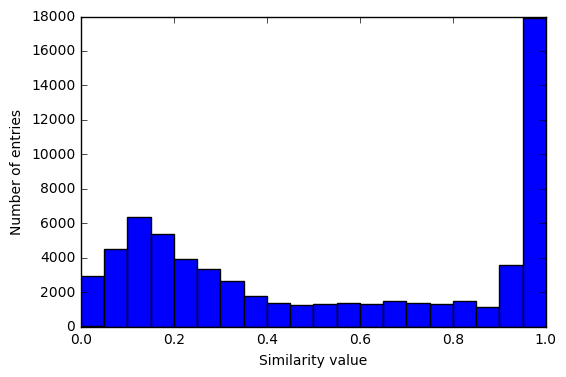

In [53]:
plt.hist(list(matching_beers.similarity), 20)
plt.xlabel('Similarity value')
plt.ylabel('Number of entries')
plt.show

This histogram is really interesting. We see that we have a lot of beers where the matching is really good. So, if we want to be sure with a very high probability that the beers are the same, then we can choose to take only the entries with a similarity value of 1. But we will loose some beers. Therefore, we can empirically test different threshold value and choose a good threshold value.

Ideally, we would do a precision and recall to get a better idea about this threshold. But it's a long and painful process since we have more than 60'000 beers in the `matching_beers` DataFrame.

In [54]:
matching_beers[matching_beers.similarity >= 0.65].tail(20)


,beer_id_beerAdvocate,beer_name_beerAdvocate,brewery_id_beerAdvocate,brewery_name_beerAdvocate,beer_name_rateBeer,brewery_name_rateBeer,similarity
33970,53146,Terrapin Pumpkinfest,2372,Terrapin Beer Company,Terrapin Side Project Pumpkinfest,Terrapin Beer Company,0.65
41650,63692,Ramstein India Pale Ale,607,High Point Brewing Company,Ramstein Pale Ale,High Point Brewing Company,0.65
10201,2638,Brew Moon Scotch Ale,1567,Brew Moon Restaurant & Microbrewery,Brew Moon Supernova Scotch Ale,Brew Moon Restaurant & Microbrewery,0.65
16828,28250,Marietta Brewing Pale Ale,597,Marietta Brewing Company,Marietta Pale Ale,Marietta Brewing Company,0.65
16845,26954,Bourbon Cherry Stout,598,Onion Pub & Brewery,Onion Cherry Bourbon Stout,Wild Onion Pub and Brewery,0.65
1719,33894,Schlafly Reserve - Imperial Stout,583,Saint Louis Brewery / Schlafly Tap Room,Schlafly Imperial Stout,Saint Louis Brewery,0.65
1723,36290,Schlafly Dry-Hopped American Pale Ale,583,Saint Louis Brewery / Schlafly Tap Room,Schlafly Pale Ale,Saint Louis Brewery,0.65
51186,9760,Extra Lager Rouge,1144,Le Cheval Blanc,Le Cheval Blanc Lager Extra-Rouge,Le Cheval Blanc,0.65
62847,64746,Barrel Aged Keyser Soze,632,Triple Rock Brewery & Alehouse,Triple Rock Keyser Soze (Bourbon Barrel Aged),Triple Rock Brewery & Alehouse,0.65
5104,63244,Gatekeeper (Sour),18915,Indigo Imp Brewery,Indigo Imp Gatekeeper Limited Release Special ...,Indigo Imp,0.65


We found that if the similarity value is above or equal to **0.65**, the matching is pretty good. If we use a threshold of 0.6, the beers are not matching well already. 

In [56]:
threshold = 0.65 # Chosen empirically
good_matching_beers = matching_beers[matching_beers.similarity >= threshold]
good_matching_beers.index = range(len(good_matching_beers))
print("Number of good matching beers: %i"%len(good_matching_beers))

Number of good matching beers: 28208


Now, we want to be sure that we don't have duplicated values.

In [59]:
len(good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()])

1608

Sadly, we have some duplicated values for the `beer_name_rateBeer`. Therefore, we need to find a way to remove them.

In [60]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

We decide that we will class the duplicated beers using the function `ratio` of the `fuzzywuzzy` library. The entry with the best ratio on the `beer_name` and the `brewery_name` will stay. The other entries will be deleted.

There's just a special case. The beers with a "generic" name. We decide that we remove all of them if the ratio is smaller then 90%. The reason is that if we don't do that, it will match the generic name to a beer with the generic name and the smallest addition. For example, the generic name being *Heineken*, the beer *Heineken dry* will be more similary than the beer *Heineken white*. And both these beers are different from the beer with the generic name.

In [61]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['brewery_name_beerAdvocate'], df.ix[i]['brewery_name_rateBeer'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio
    max_ratio = np.max(ratio)
    beer_test = df.ix[df.index[0]].beer_name_rateBeer
    if " " in beer_test:
        index_to_remove.extend(list(df[df.ratio != max_ratio].index))
    else:
        if max_ratio < 0.9:
            index_to_remove.extend(list(df.index))
        else:
            index_to_remove.extend(list(df[df.ratio != max_ratio].index))

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [62]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

Now that we removed some duplicated beers, we will only have the beers with the same ratio left. So, let's check the duplicated beers again.

In [63]:
len(good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()])

69

In [64]:
duplicated_beer_names = good_matching_beers[good_matching_beers.beer_name_rateBeer.duplicated()].beer_name_rateBeer.unique()

Print the duplicated beers that remain to see what is the problem.

In [67]:
index_to_remove = []
for bn in duplicated_beer_names:
    df = good_matching_beers[good_matching_beers.beer_name_rateBeer == bn]
    ratio = []
    for i in df.index:
        val1 = fuzz.ratio(df.ix[i]['beer_name_beerAdvocate'], df.ix[i]['beer_name_rateBeer'])/100
        val2 = fuzz.ratio(df.ix[i]['beer_name_rateBeer'], df.ix[i]['beer_name_beerAdvocate'])/100
        ratio.append(val1*val2)
    df['ratio'] = ratio 
    index_to_remove.extend(list(df.index))
    print(df[['beer_name_rateBeer', 'beer_name_beerAdvocate', 'similarity', 'ratio']])
    print()

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


          beer_name_rateBeer                  beer_name_beerAdvocate  \
257  KB Double Chocolate Ale  KB Double Chocolate Ale  First Edition   
258  KB Double Chocolate Ale  KB Double Chocolate Ale Second Edition   

     similarity   ratio  
257         1.0  0.5625  
258         1.0  0.5625  

          beer_name_rateBeer beer_name_beerAdvocate  similarity   ratio
388   Harpoon Saison Various         Harpoon Saison         1.0  0.6084
1720  Harpoon Saison Various         Saison Various         1.0  0.6084

         beer_name_rateBeer      beer_name_beerAdvocate  similarity   ratio
2736  Trafalgar Hop Nouveau  Trafalgar Hop Nouveau 2009         1.0  0.7921
2740  Trafalgar Hop Nouveau  Trafalgar Hop Nouveau 2010         1.0  0.7921
2744  Trafalgar Hop Nouveau  Trafalgar Hop Nouveau 2011         1.0  0.7921

                 beer_name_rateBeer  \
3488  Shepherd Neame Christmas Ale    
3496  Shepherd Neame Christmas Ale    
3500  Shepherd Neame Christmas Ale    
3504  Shepherd Neame Chris

Most of the remaining duplicates are difficult to match. A good example can be this one:
                
                        beer_name_rateBeer         |      beer_name_beerAdvocate
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2003  
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2004
                Green Flash Anniversary Strong Ale | Green Flash Anniversary Ale 2005
                
With just the name information, we cannot say which `beer_name` in the *beerAdvocate* dataset is corresponding to the one in the *rateBeer* dataset. Therefore, we decide to remove these remaining duplicates.

In [68]:
good_matching_beers = good_matching_beers.drop(index_to_remove)
good_matching_beers.index = range(len(good_matching_beers))

We have now our **final** DataFrame of beers that matched together. We just print the number of beers we could matched and save it in a CSV file.

In [75]:
print("Number of beers that matched: %i"%len(good_matching_beers))

Number of beers that matched: 26544


We just add the ID of the *rateBeer* dataset for easier research later.

In [71]:
beer_id_rateBeer = rateBeer.set_index('beer_name').to_dict()['beer_id']
brewery_id_rateBeer = rateBeer.set_index('brewery_name').to_dict()['brewery_id']

In [72]:
beer_id_rateBeer_list = []
brewery_id_rateBeer_list = []
for i in range(len(good_matching_beers)):
    beer_id_rateBeer_list.append(beer_id_rateBeer[good_matching_beers.ix[i].beer_name_rateBeer])
    brewery_id_rateBeer_list.append(brewery_id_rateBeer[good_matching_beers.ix[i].brewery_name_rateBeer])
good_matching_beers['beer_id_rateBeer'] = beer_id_rateBeer_list
good_matching_beers['brewery_id_rateBeer'] = brewery_id_rateBeer_list

In [73]:
# Rearrange columns to be beautiful =)
good_matching_beers = good_matching_beers[['beer_id_beerAdvocate', 'beer_name_beerAdvocate', 'brewery_id_beerAdvocate', 'brewery_name_beerAdvocate', 'beer_id_rateBeer', 'beer_name_rateBeer', 'brewery_id_rateBeer', 'brewery_name_rateBeer', 'similarity']]

In [74]:
# Save the Cleaned CSV
good_matching_beers.to_csv('./data/matching_beers.csv', index=False)

